In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-09-12 01:03:30--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-09-12 01:03:30 (4.48 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8


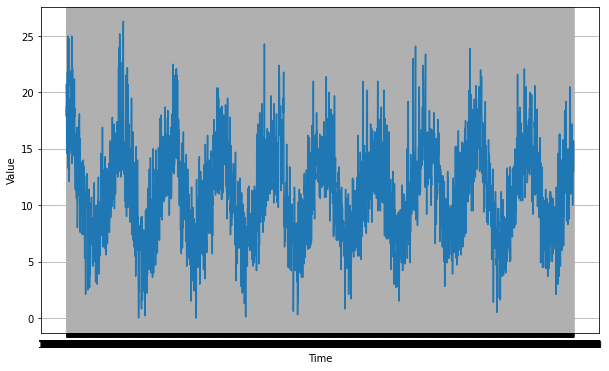

In [6]:
''' import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc '''

import pandas as pd

df = pd.read_csv('/tmp/daily-min-temperatures.csv')
print(df.head())

series = np.array(df.loc[:,'Temp'])
time = np.array(df.loc[:,'Date'])
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [11]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds, verbose=1)
    return forecast

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 30
batch_size = 250
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
                            tf.keras.layers.Conv1D(filters=30, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
                            tf.keras.layers.Dense(1),
                            tf.keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=1)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 24ms/step - loss: 45.8397 - mae: 46.3397
Epoch 2/100
10/10 [==============================] - 0s 27ms/step - loss: 45.0955 - mae: 45.5955
Epoch 3/100
10/10 [==============================] - 0s 27ms/step - loss: 43.9644 - mae: 44.4644
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 42.5896 - mae: 43.0896
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 41.0080 - mae: 41.5080
Epoch 6/100
10/10 [==============================] - 0s 22ms/step - loss: 39.2149 - mae: 39.7149
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 37.1912 - mae: 37.6912
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 34.9088 - mae: 35.4088
Epoch 9/100
10/10 [==============================] - 0s 26ms/step - loss: 32.3374 - mae: 32.8374
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

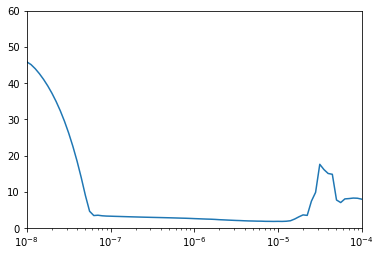

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [62]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
                            tf.keras.layers.Conv1D(filters=30, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                            tf.keras.layers.Dense(25),
                            tf.keras.layers.Dense(10),
                            tf.keras.layers.Dense(5),
                            tf.keras.layers.Dense(1),
                            tf.keras.layers.Lambda(lambda x: x * 200.0)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, verbose=1)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 0s 19ms/step - loss: 7.5862 - mae: 8.0754
Epoch 2/150
25/25 [==============================] - 0s 19ms/step - loss: 5.4904 - mae: 5.9792
Epoch 3/150
25/25 [==============================] - 0s 19ms/step - loss: 4.6248 - mae: 5.1136
Epoch 4/150
25/25 [==============================] - 1s 20ms/step - loss: 3.9397 - mae: 4.4263
Epoch 5/150
25/25 [==============================] - 0s 19ms/step - loss: 3.2995 - mae: 3.7788
Epoch 6/150
25/25 [==============================] - 0s 19ms/step - loss: 3.0595 - mae: 3.5382
Epoch 7/150
25/25 [==============================] - 0s 20ms/step - loss: 2.7501 - mae: 3.2254
Epoch 8/150
25/25 [==============================] - 1s 22ms/step - loss: 2.5511 - mae: 3.0231
Epoch 9/150
25/25 [==============================] - 0s 19ms/step - loss: 2.3022 - mae: 2.7697
Epoch 10/150
25/25 [==============================] - 1s 20ms/step - loss: 1.8589 - mae: 2.3147
Epoch 11/150
25/25 [=============================

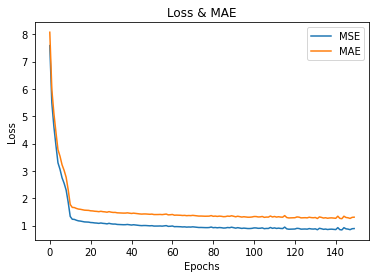

In [63]:
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['mae'], label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss & MAE')
plt.legend()

In [64]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

114/114 [==============================] - 1s 10ms/step


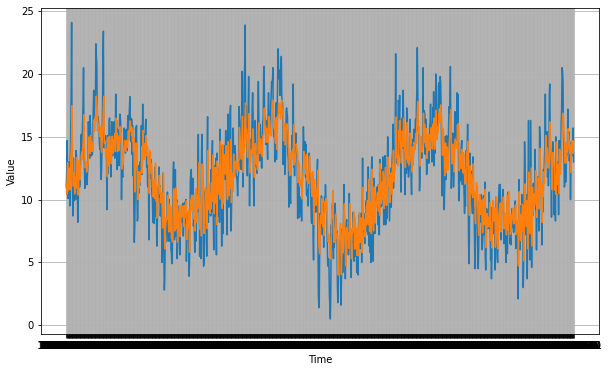

In [65]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [66]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8300208

In [67]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.230753 10.405014 11.723257 ... 13.707307 13.704966 14.65507 ]
